In [1]:
import scipy
import matplotlib
import numpy as np
import pandas as pd
import numpy.ma as ma
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn import linear_model
from colors import red

%matplotlib inline  
DEFAULT_DPI = 600
matplotlib.rcParams['figure.figsize'] = (8, 5)

## Dataset

In [2]:
def convert(s):
    d = {"пн": 1, "вт": 2, "ср": 3, "чт": 4, "пт": 5, "сб": 6, "вс": 7, "-": 0, "": 0}
    if s in d.keys():
        return d[s]
    else:
        return float(s)

/home/y_rebryk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: ConversionWarning: Some errors were detected !
    Line #624 (got 17 columns instead of 18)
  """


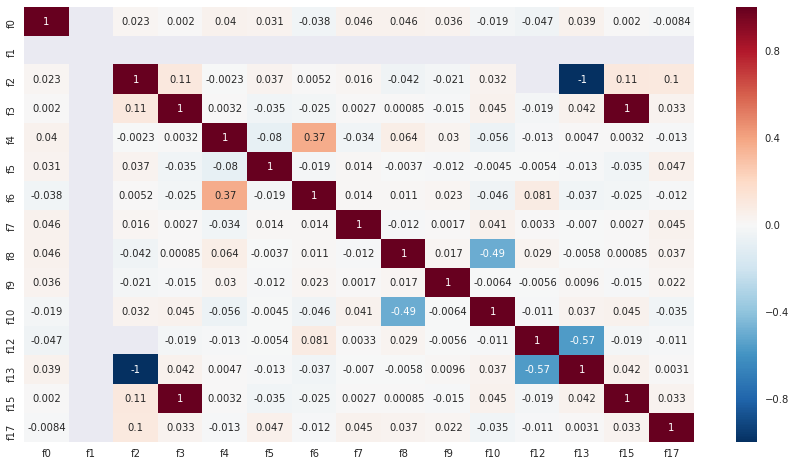

In [3]:
ncols = 18
data = np.genfromtxt("data/dataset_16.dms", 
                     delimiter="\t", 
                     converters=dict(zip(range(ncols), [convert] * ncols)), 
                     invalid_raise=False)
dataT = data.T

df = pd.DataFrame(dataT)

_, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(df.corr(), annot=True, ax=ax)

## Processing

### NaN values

In [4]:
theshold = 0.5
columns_to_remove = []

for i in range(ncols):
    null_ratio = df.iloc[:, i].isnull().sum() / len(df)
    msg = "Percent of NaN for f{}: {:3.2f}%".format(i, 100 * null_ratio)
    
    if null_ratio:
        if null_ratio > theshold:
            columns_to_remove.append("f{}".format(i))
            
        print(red(msg) if null_ratio > theshold else msg)

Percent of NaN for f2: 3.30%
Percent of NaN for f11: 100.00%
Percent of NaN for f14: 58.46%
Percent of NaN for f16: 78.38%


As we can see **f11**, **f14**, **f16** have a lot of NaN.

In [5]:
df = df.drop(columns_to_remove, axis=1)
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f12,f13,f15,f17
0,1.0,1.0,10.0,43.0,5825543.0,69.0,60.0,0.0,1.407607e+09,0.0,-24.0,0.0,1.414776e+09,424668.0,3.0
1,2.0,1.0,334.0,129.0,31.0,112227.0,2.0,1.0,1.415700e+09,0.0,-29.0,0.0,1.386786e+09,1274004.0,21.0
2,2.0,1.0,1.0,5.0,5825543.0,315.0,25219.0,1.0,1.415429e+09,0.0,-26.0,0.0,1.415612e+09,49380.0,16.0
3,1.0,1.0,422.0,2.0,5825543.0,392.0,44.0,1.0,1.411245e+09,0.0,22.0,0.0,1.379156e+09,19752.0,20.0
4,1.0,1.0,0.0,580.0,7699829.0,500.0,161068.0,1.0,1.354123e+09,0.0,26.0,0.0,1.415716e+09,5728080.0,18.0


### Correlation

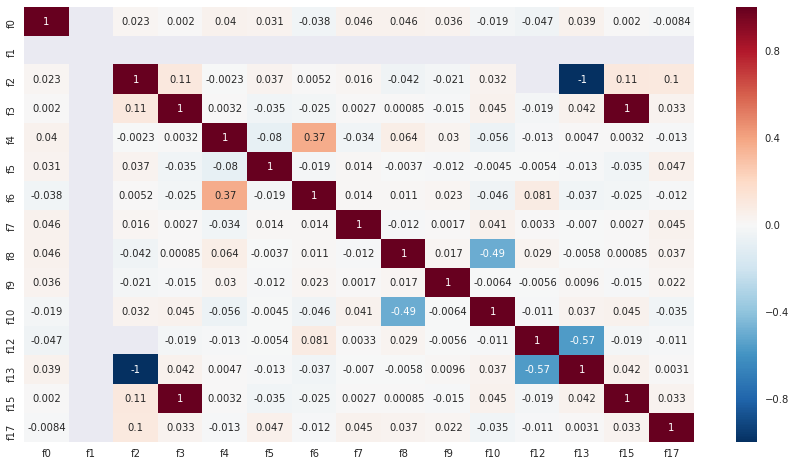

In [6]:
_, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(df.corr(), annot=True, ax=ax)

### f2 and f13 are linear dependent

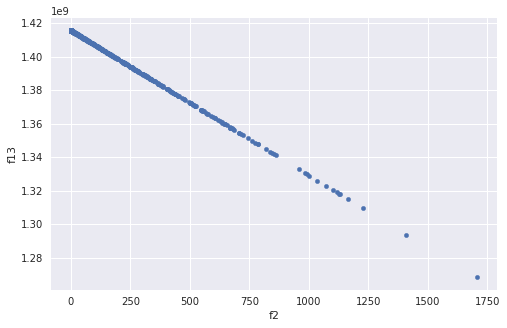

In [7]:
df.plot.scatter("f2", "f13")

In [8]:
indices = df["f2"].notnull() & df["f13"].notnull()
model = linear_model.LinearRegression()
model.fit(df[indices]["f2"].reshape(-1, 1), df[indices]["f13"])
print("Coefficient = {}".format(model.coef_))

Coefficient = [-86443.44532501]


/home/y_rebryk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


### f3 and f15 are linear dependent

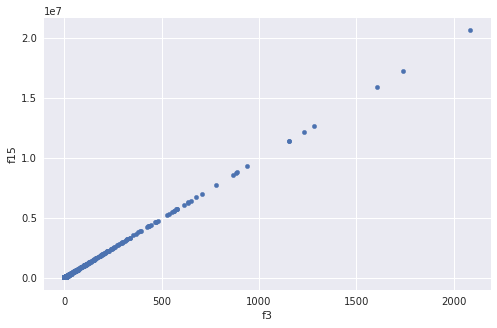

In [9]:
df.plot.scatter("f3", "f15")

In [10]:
indices = df["f3"].notnull() & df["f15"].notnull()
model = linear_model.LinearRegression()
model.fit(df[indices]["f3"].reshape(-1, 1), df[indices]["f15"])
print("Coefficient = {}".format(model.coef_))

Coefficient = [ 9876.]


/home/y_rebryk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


### f4 and f6 are dependent somehow

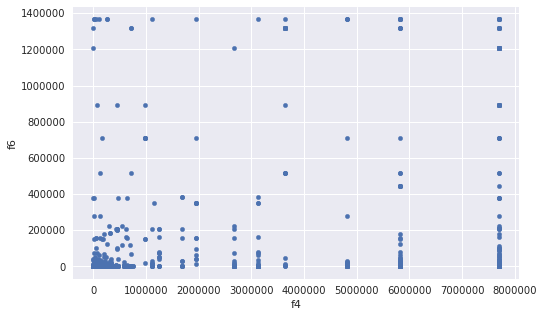

In [11]:
df.plot.scatter("f4", "f6")

### f8 and f10

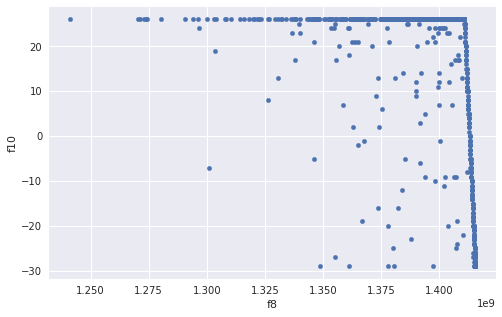

In [12]:
df.plot.scatter("f8", "f10")

### f12 and f13

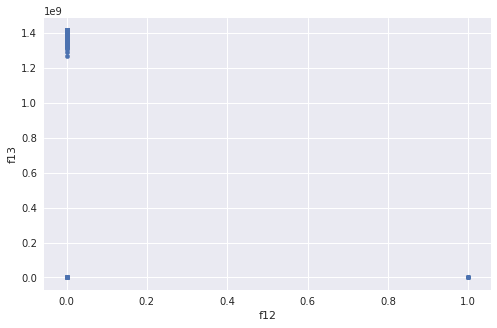

In [13]:
df.plot.scatter("f12", "f13")

* We can drop **f2** because it is dependent on **f13**.
* We can drop **f3** because it is dependent on **f15**.

### Values distributions

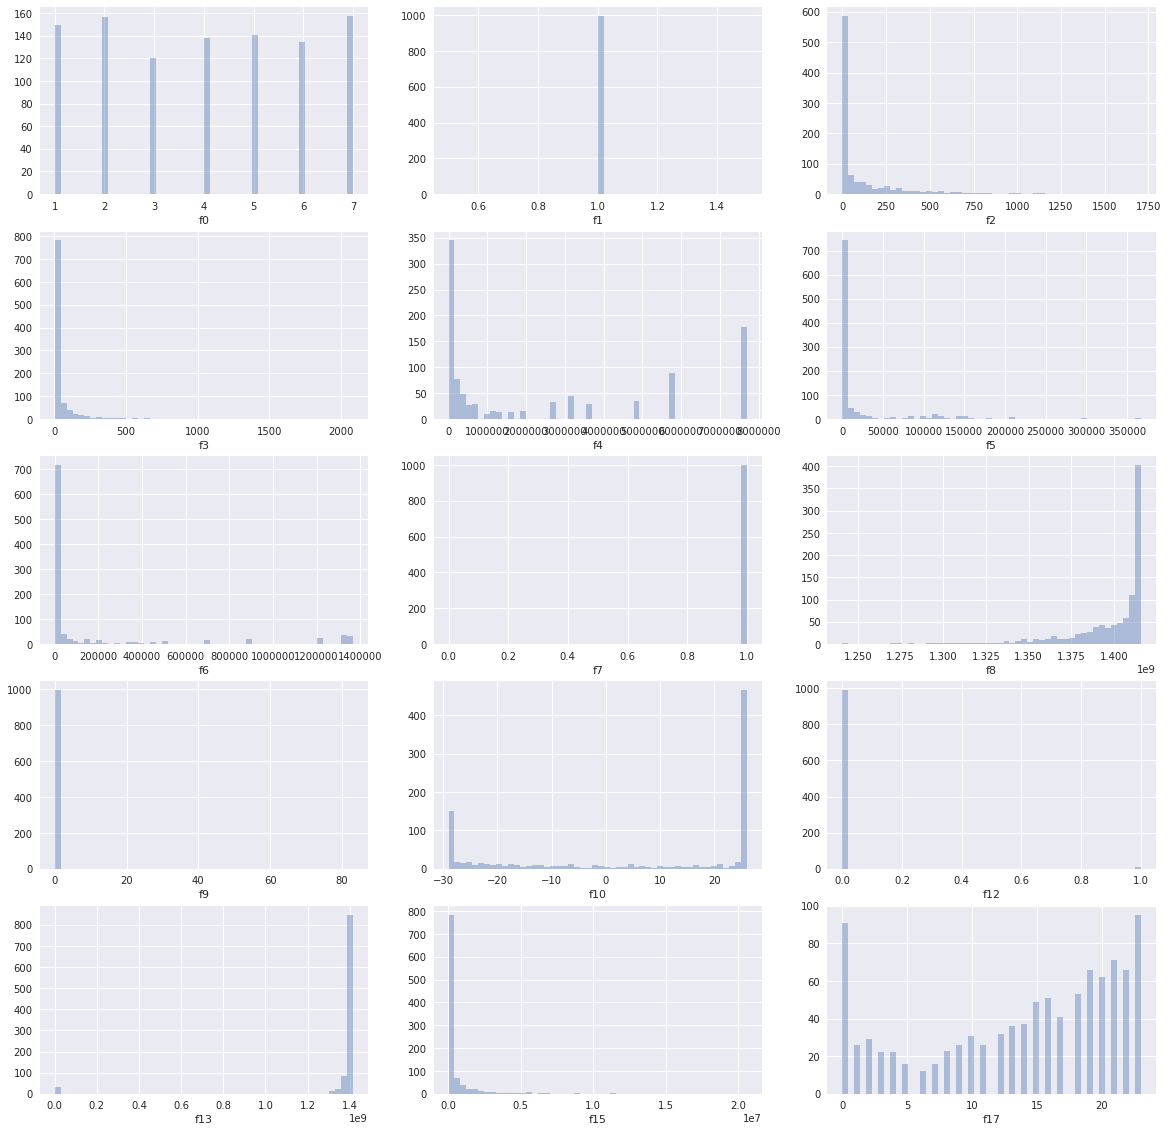

In [14]:
_, ax = plt.subplots(figsize=(20, 20), nrows=5, ncols=3)

for index in range(15):
    sns.distplot(df.iloc[:, index].dropna(), bins=50, kde=False, ax=ax[index // 3, index % 3])

We can see that **f1, f7, f9, f12** are almost constants. 

### Drop bad columns 

* We can drop **f2** because it is dependent on **f13**.
* We can drop **f3** because it is dependent on **f15**.
* **f1, f7, f9, f12** are almost constants.
* **f11, f14, f16** have a lot of NaN (we have dropped them already).

In [15]:
df = df.drop(["f1", "f2", "f3", "f7", "f9", "f12"], axis=1)
df.head()

,f0,f4,f5,f6,f8,f10,f13,f15,f17
0,1.0,5825543.0,69.0,60.0,1.407607e+09,-24.0,1.414776e+09,424668.0,3.0
1,2.0,31.0,112227.0,2.0,1.415700e+09,-29.0,1.386786e+09,1274004.0,21.0
2,2.0,5825543.0,315.0,25219.0,1.415429e+09,-26.0,1.415612e+09,49380.0,16.0
3,1.0,5825543.0,392.0,44.0,1.411245e+09,22.0,1.379156e+09,19752.0,20.0
4,1.0,7699829.0,500.0,161068.0,1.354123e+09,26.0,1.415716e+09,5728080.0,18.0


### PCA

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=9)

data = df.as_matrix().copy()
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)
pca.fit(data)

print(pca.explained_variance_ratio_)

[ 0.17242986  0.14959015  0.1194267   0.11497047  0.11407979  0.10466674
  0.10110459  0.06808398  0.05564774]


We see, that all features have very close values. <br>
So it is better not to drop any columns.